<a href="https://colab.research.google.com/github/EA-park/AIFFEL_datathon/blob/pea/%5BDatathon%5D%EC%84%B8%EA%B3%84%ED%96%89%EB%B3%B5%EB%B3%B4%EA%B3%A0%EC%84%9C_%EC%84%B8%EA%B3%84%EC%A0%95%EB%B3%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#목차

1. 데이터 정리
 - 연도별 피처 이름(columns) 정리    
 - 연도별 국가 목록(row) 정리
2. 결측치 확인
 - None    
 - None 외 결측치 정리
3. 피처별 분포 확인
 - skewness    
 -이상치
4. 피처의 필요성 확인
 * 피처별 가중치 확인
    - GDP의 가중치가 가장 높다 -> 특정 국가의 행복지수에 GDP가 가장 큰 영향
 * 상관분석
    - 상위 국가에만 영향 주는 피처 존재 -> Freedom, Corruption, Generosity
    - Dystopia Residual은 Corruption, Generosity보다 값이 더 높은데, 2018-2019년에는 빠진 이유는 무엇인지?
     - Generosity는 가중치가 Corruption보다 높은데 비해, 상관분석에서의 관계성은 가장 낮다
 * 추가적인 피처를 넣는다면?
    - '카카오같이가치'에서 조사한 2018년 한국인의 행복지수는 5.18     
    (정답이라고 가정)
    - Suidcide Rate = -연간 자살률      
    (0~1로 normalization -> 행복지수 결과 확인 -> 가중치 조절)
    - x축 rank, y축 국가별 연간 자살률 그래프에서 경향 확인해보기
5. 대륙별 행복지수




#설정

라이브러리 설정

In [49]:
import sys

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

경로 설정

In [2]:
from os.path import join
from google.colab import drive

In [3]:
ROOT = '/content/gdrive'
drive.mount(ROOT)

Mounted at /content/gdrive


In [4]:
PROJ = 'MyDrive/AIFFEL/[Datathon] 세계행복보고서'
WORKING_DIR = join(ROOT, PROJ)

#데이터 정리

In [416]:
happiness2015 = pd.read_csv(join(WORKING_DIR, '2015.csv'))
happiness2016 = pd.read_csv(join(WORKING_DIR, '2016.csv'))
happiness2017 = pd.read_csv(join(WORKING_DIR, '2017.csv'))
happiness2018 = pd.read_csv(join(WORKING_DIR, '2018.csv'))
happiness2019 = pd.read_csv(join(WORKING_DIR, '2019.csv'))

연도별 피처 이름(columns) 정리

In [417]:
keys2015 = happiness2015.keys().tolist()
keys2015[5:5]=['-', '-']

keys2016 = happiness2016.keys().tolist()
keys2016.insert(4,'-')

keys2017 = happiness2017.keys().tolist()
keys2017.insert(1, '-')
keys2017.insert(4, '-')
keys2017[5], keys2017[6] = keys2017[6], keys2017[5]
keys2017[-3], keys2017[-2] = keys2017[-2], keys2017[-3]
#map(keys2017.insert, [1, 4], ['-', '-'])

keys2018 = happiness2018.keys().tolist()
keys2018.insert(1, '-')
keys2018[0], keys2018[2] = keys2018[2], keys2018[0]
keys2018[4:4]=['-', '-', '-']
keys2018[-2], keys2018[-1] = keys2018[-1], keys2018[-2]
keys2018.append('-')

keys2019 = happiness2019.keys().tolist()
keys2019.insert(1, '-')
keys2019[0], keys2019[2] = keys2019[2], keys2019[0]
keys2019[4:4]=['-', '-', '-']
keys2019[-2], keys2019[-1] = keys2019[-1], keys2019[-2]
keys2019.append('-')

features = ['Country', 'Region', 'Rank', 'Score', 'Standard Error', 'LCI', 'UCI', 'GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']
df_keys = pd.DataFrame(index=np.linspace(2015,2019,5,dtype=int), data=[keys2015, keys2016, keys2017, keys2018, keys2019], columns=features)
display(df_keys)

,Country,Region,Rank,Score,Standard Error,LCI,UCI,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual
2015,Country,Region,Happiness Rank,Happiness Score,Standard Error,-,-,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
2016,Country,Region,Happiness Rank,Happiness Score,-,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
2017,Country,-,Happiness.Rank,Happiness.Score,-,Whisker.low,Whisker.high,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Trust..Government.Corruption.,Generosity,Dystopia.Residual
2018,Country or region,-,Overall rank,Score,-,-,-,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,-
2019,Country or region,-,Overall rank,Score,-,-,-,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,-


In [418]:
happiness2015.rename(columns = {'Happiness Rank':'Rank','Happiness Score':'Score', 'Economy (GDP per Capita)':'GDP', 'Family':'Social Support', 'Health (Life Expectancy)':'Healthy Life Expectancy', 'Trust (Government Corruption)':'Corruption'},inplace=True)
happiness2016.rename(columns = {'Happiness Rank':'Rank','Happiness Score':'Score', 'Lower Confidence Interval':'LCI', 'Upper Confidence Interval':'UCI', 'Economy (GDP per Capita)':'GDP', 'Family':'Social Support', 'Health (Life Expectancy)':'Healthy Life Expectancy', 'Trust (Government Corruption)':'Corruption'},inplace=True)
happiness2017.rename(columns = {'Happiness.Rank':'Rank','Happiness.Score':'Score', 'Economy..GDP.per.Capita.':'GDP', 'Family':'Social Support', 'Health..Life.Expectancy.':'Healthy Life Expectancy', 'Trust..Government.Corruption.':'Corruption', 'Dystopia.Residual':'Dystopia Residual', 'Whisker.low':'LCI', 'Whisker.high':'UCI'},inplace=True)
happiness2018.rename(columns = {'Country or region':'Country','Overall rank':'Rank', 'GDP per capita':'GDP', 'Freedom to make life choices':'Freedom','Social support':'Social Support', 'Healthy life expectancy':'Healthy Life Expectancy', 'Perceptions of corruption':'Corruption'},inplace=True)
happiness2019.rename(columns = {'Country or region':'Country','Overall rank':'Rank', 'GDP per capita':'GDP', 'Freedom to make life choices':'Freedom','Social support':'Social Support', 'Healthy life expectancy':'Healthy Life Expectancy', 'Perceptions of corruption':'Corruption'},inplace=True)
# 바로 위의 셀을 재실행해서 이름 변경 확인

연도별 국가 목록(row) 정리

#결측치 확인

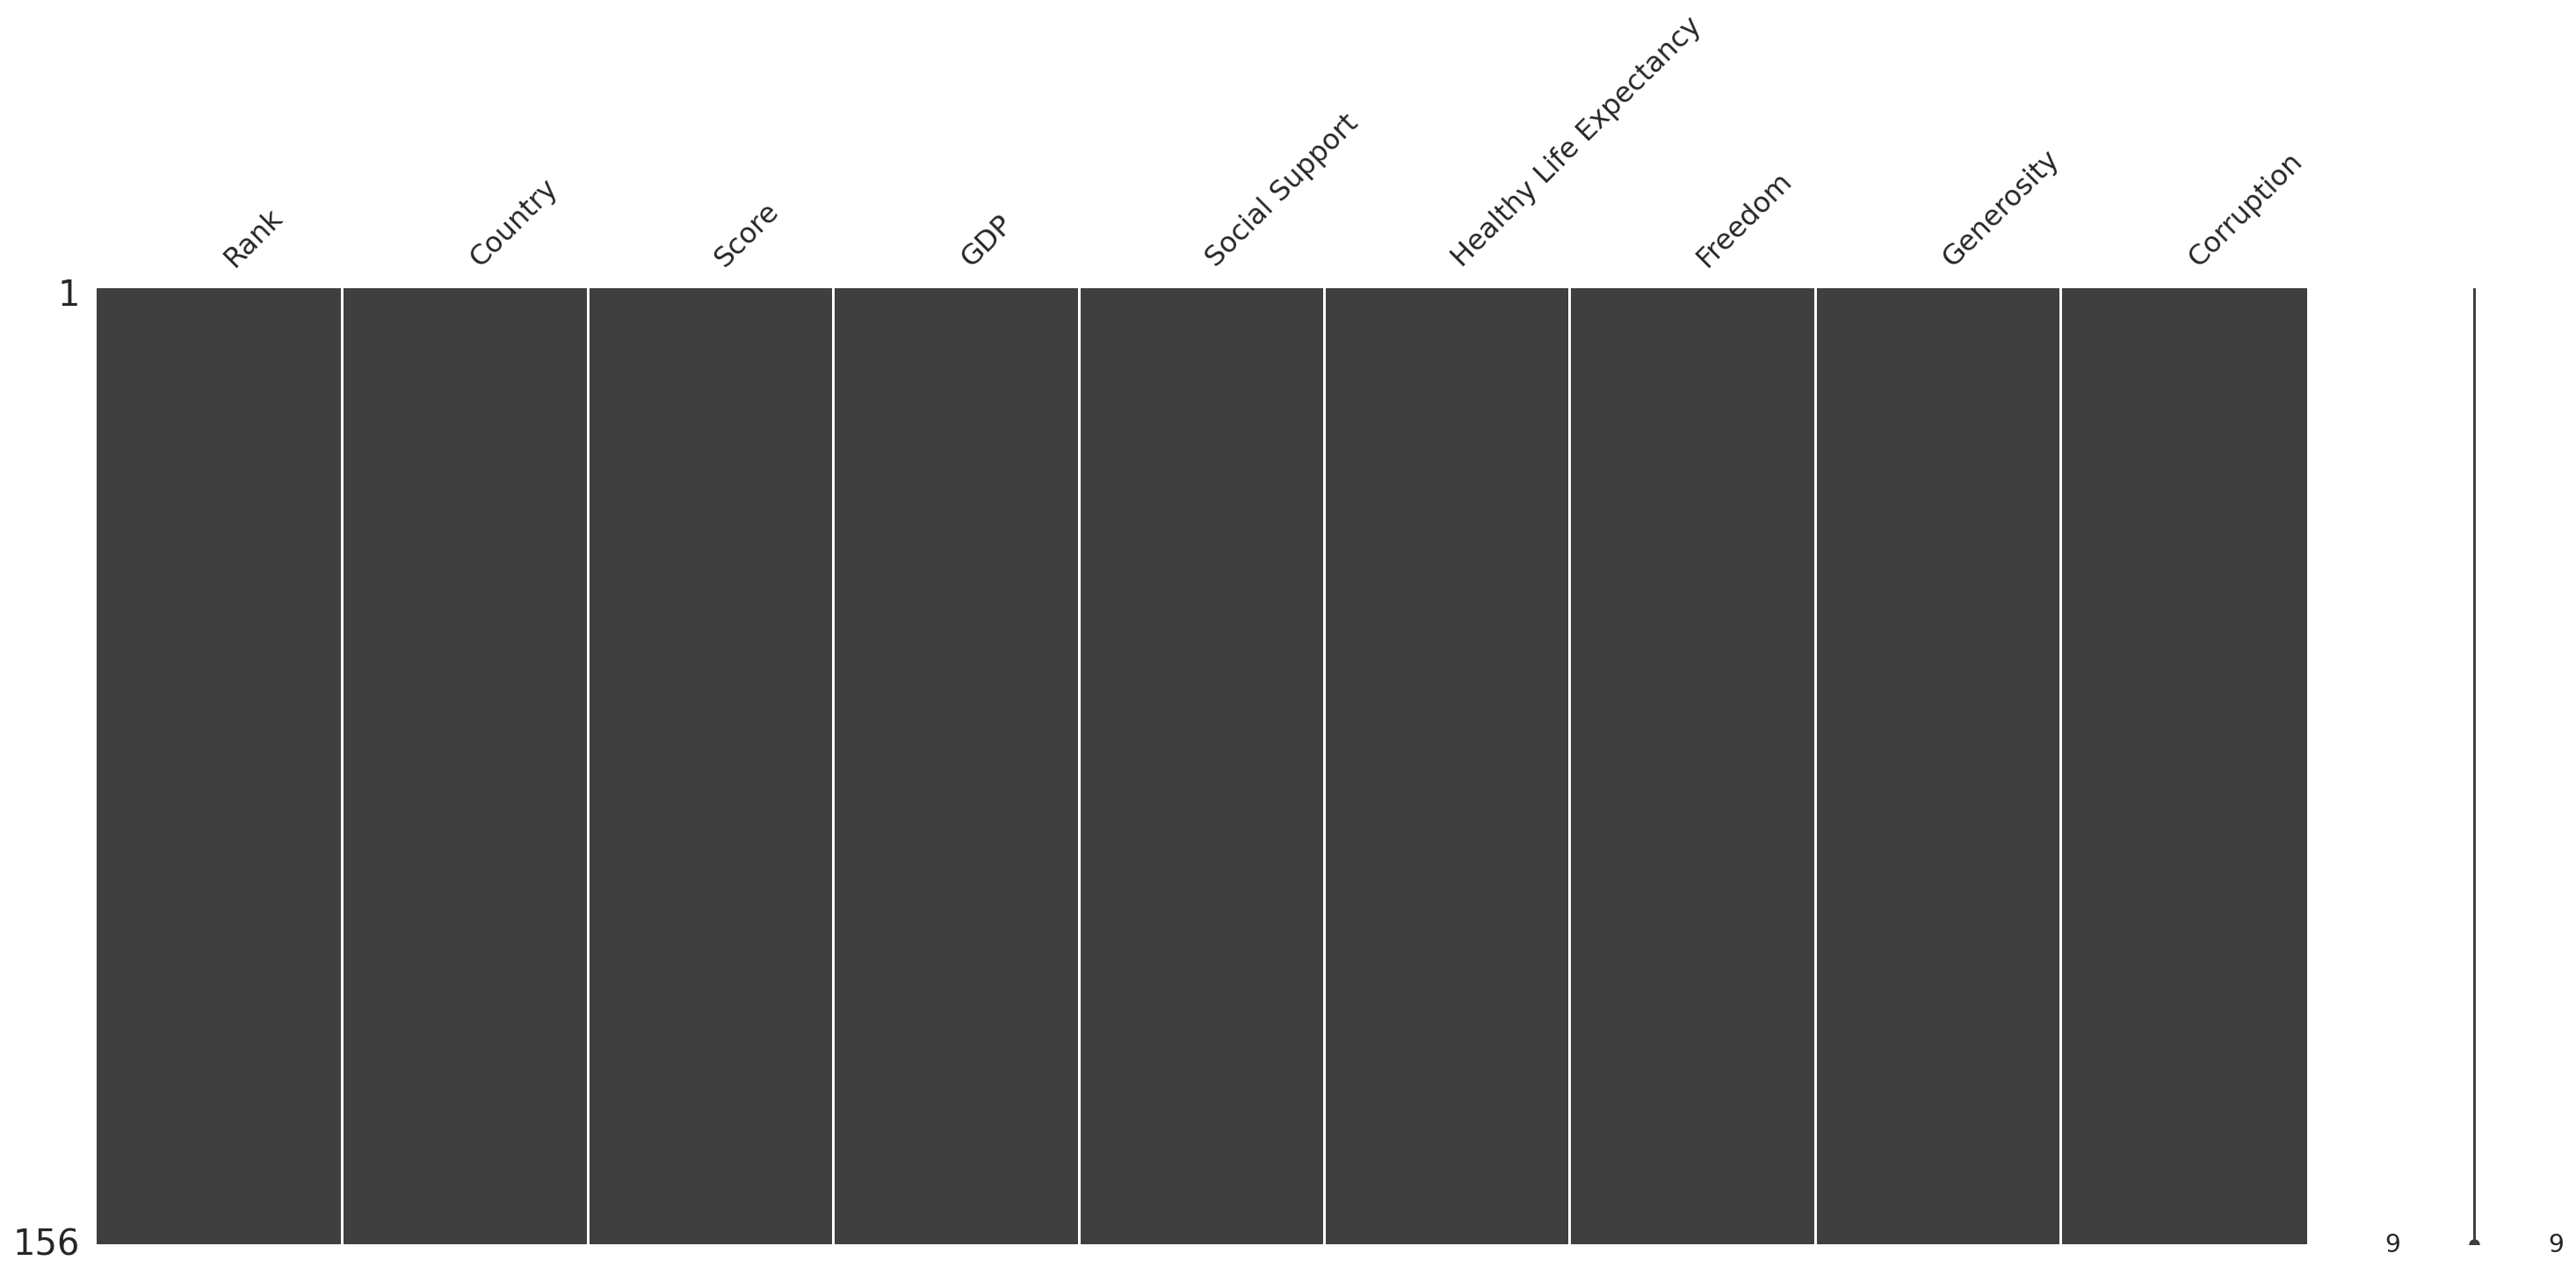

In [419]:
msno.matrix(happiness2019)
plt.show()

None 외 결측치 정리

#피처별 분포 확인

###목적변수 skewness 확인

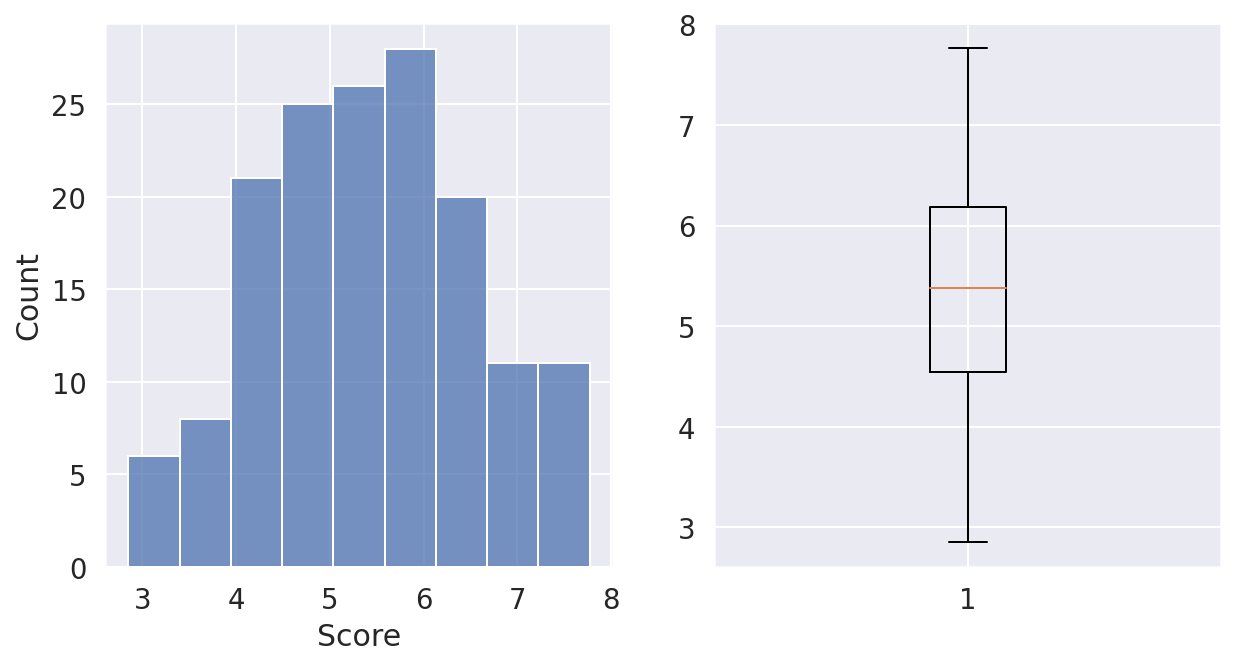

In [420]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
sns.histplot(happiness2019.Score)
plt.subplot(1,2,2)
plt.boxplot(happiness2019.Score)
plt.show()

피처 이상치 확인

In [421]:
keys = happiness2019.keys()
keys = keys[3:]

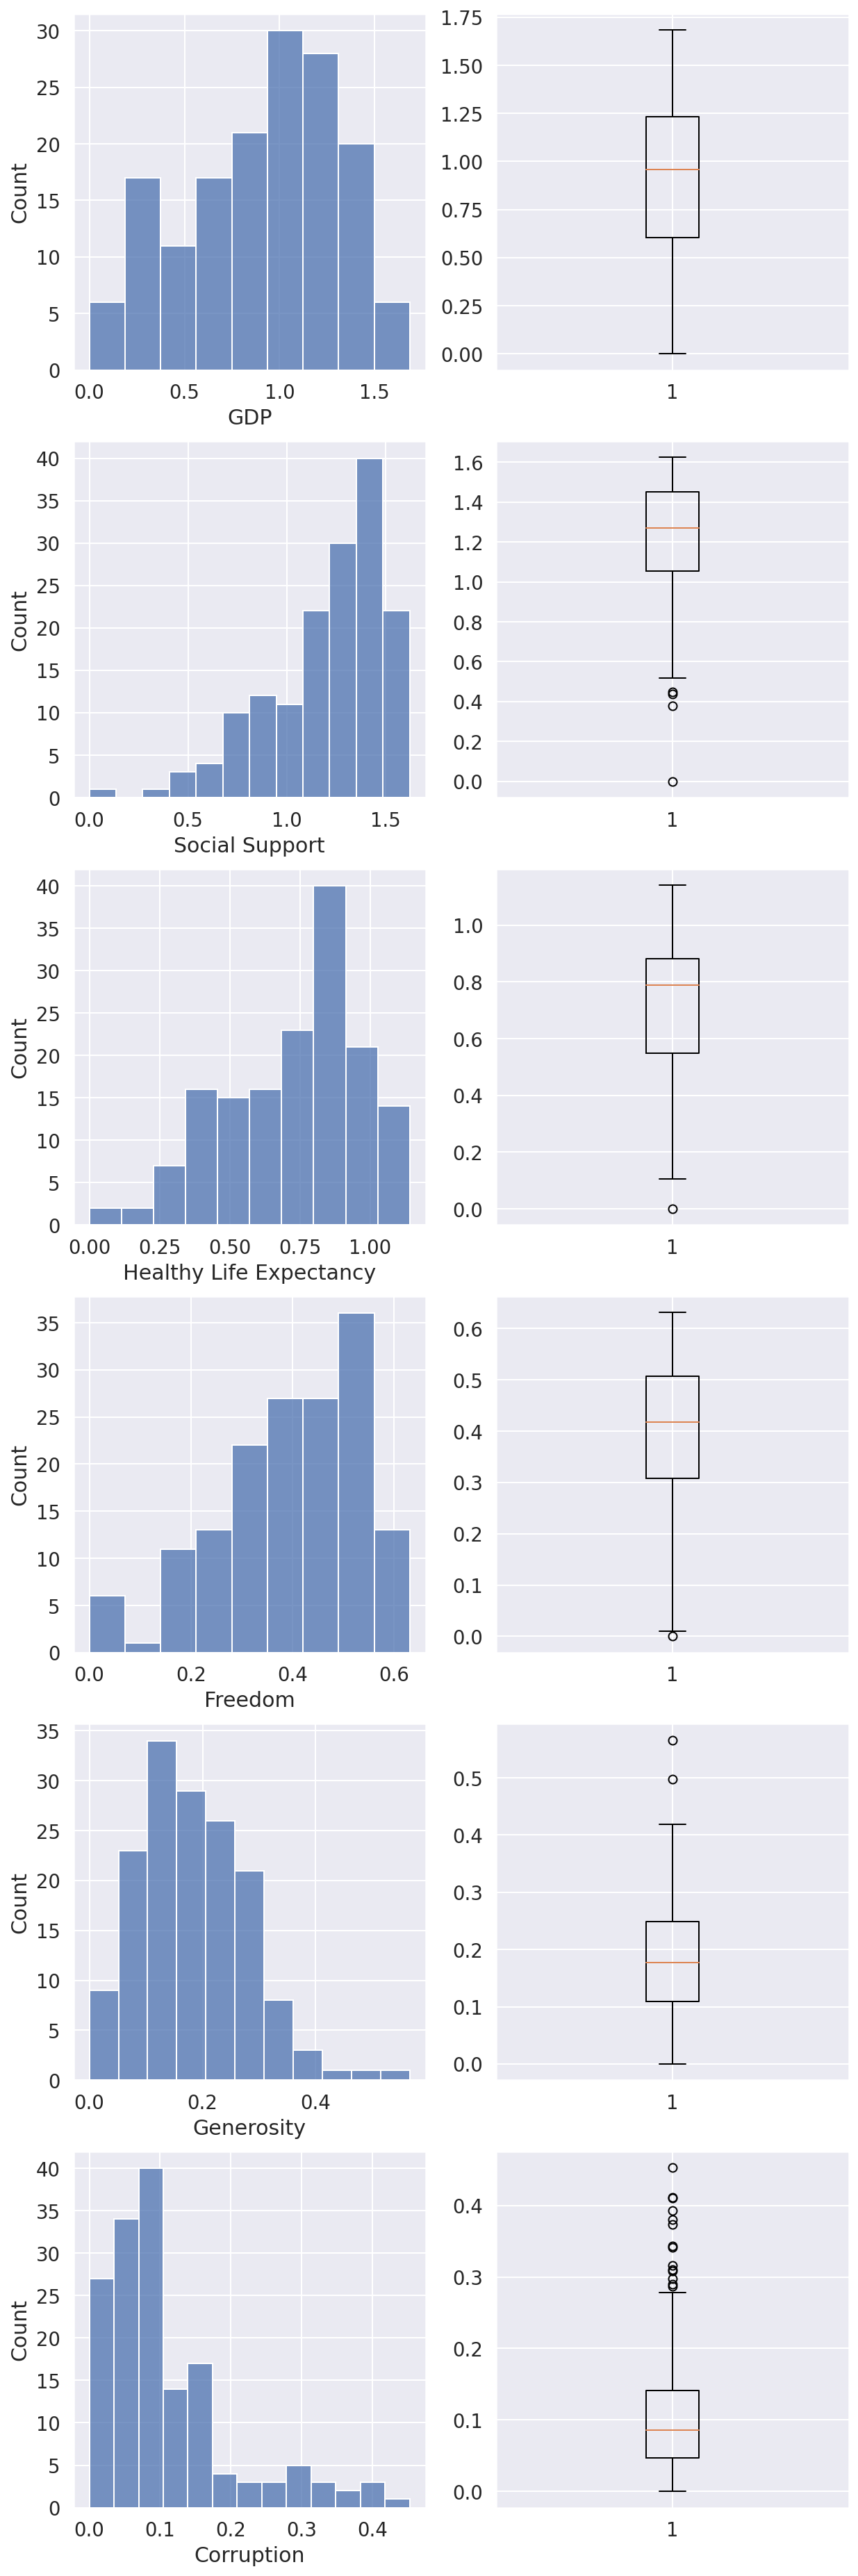

In [422]:
plt.figure(figsize=[10,50])
for iter, key in enumerate(keys):
    plt.subplot(9,2,2*iter+1)
    sns.histplot(happiness2019[key])
    plt.subplot(9,2,2*iter+2)
    plt.boxplot(happiness2019[key])
plt.show()



---



#피처의 필요성 확인

In [423]:
features_tmp = features[3:4] + features[7:]
happiness = [happiness2015, happiness2016, happiness2017, happiness2018, happiness2019]

각 피처별 가중치 확인
- score가 각 피처의 단순 합산인 것은, 피처의 값에 이미 가중치가 계산되었다고 판단
- 각 피처의 최대값(만점) 정보가 없어서, 전체 데이터에서 각 피처의 최대값을 확인함

In [424]:
statistics = {i:{'max':None, 'min':None} for i in features_tmp}
statistics

{'Score': {'max': None, 'min': None},
 'GDP': {'max': None, 'min': None},
 'Social Support': {'max': None, 'min': None},
 'Healthy Life Expectancy': {'max': None, 'min': None},
 'Freedom': {'max': None, 'min': None},
 'Corruption': {'max': None, 'min': None},
 'Generosity': {'max': None, 'min': None},
 'Dystopia Residual': {'max': None, 'min': None}}

In [425]:
for index, feature in enumerate(features_tmp):
    print(feature)
    max_tmp = []
    min_tmp = []
    for year in happiness:
        max_tmp.append(year[feature].max())
        min_tmp.append(year[feature].min())
    statistics[feature]['max'] = max(max_tmp)
    statistics[feature]['min'] = min(min_tmp)

statistics

Score


TypeError: ignored

In [ ]:
statistics

In [426]:
max = [statistics[i]['max'] for i in features[2:-1]]
print(sum(max))

plt.figure(figsize=(15,5))
plt.bar(features[2:-1], max)
plt.show()

KeyError: ignored

###1. Dystopia Residual

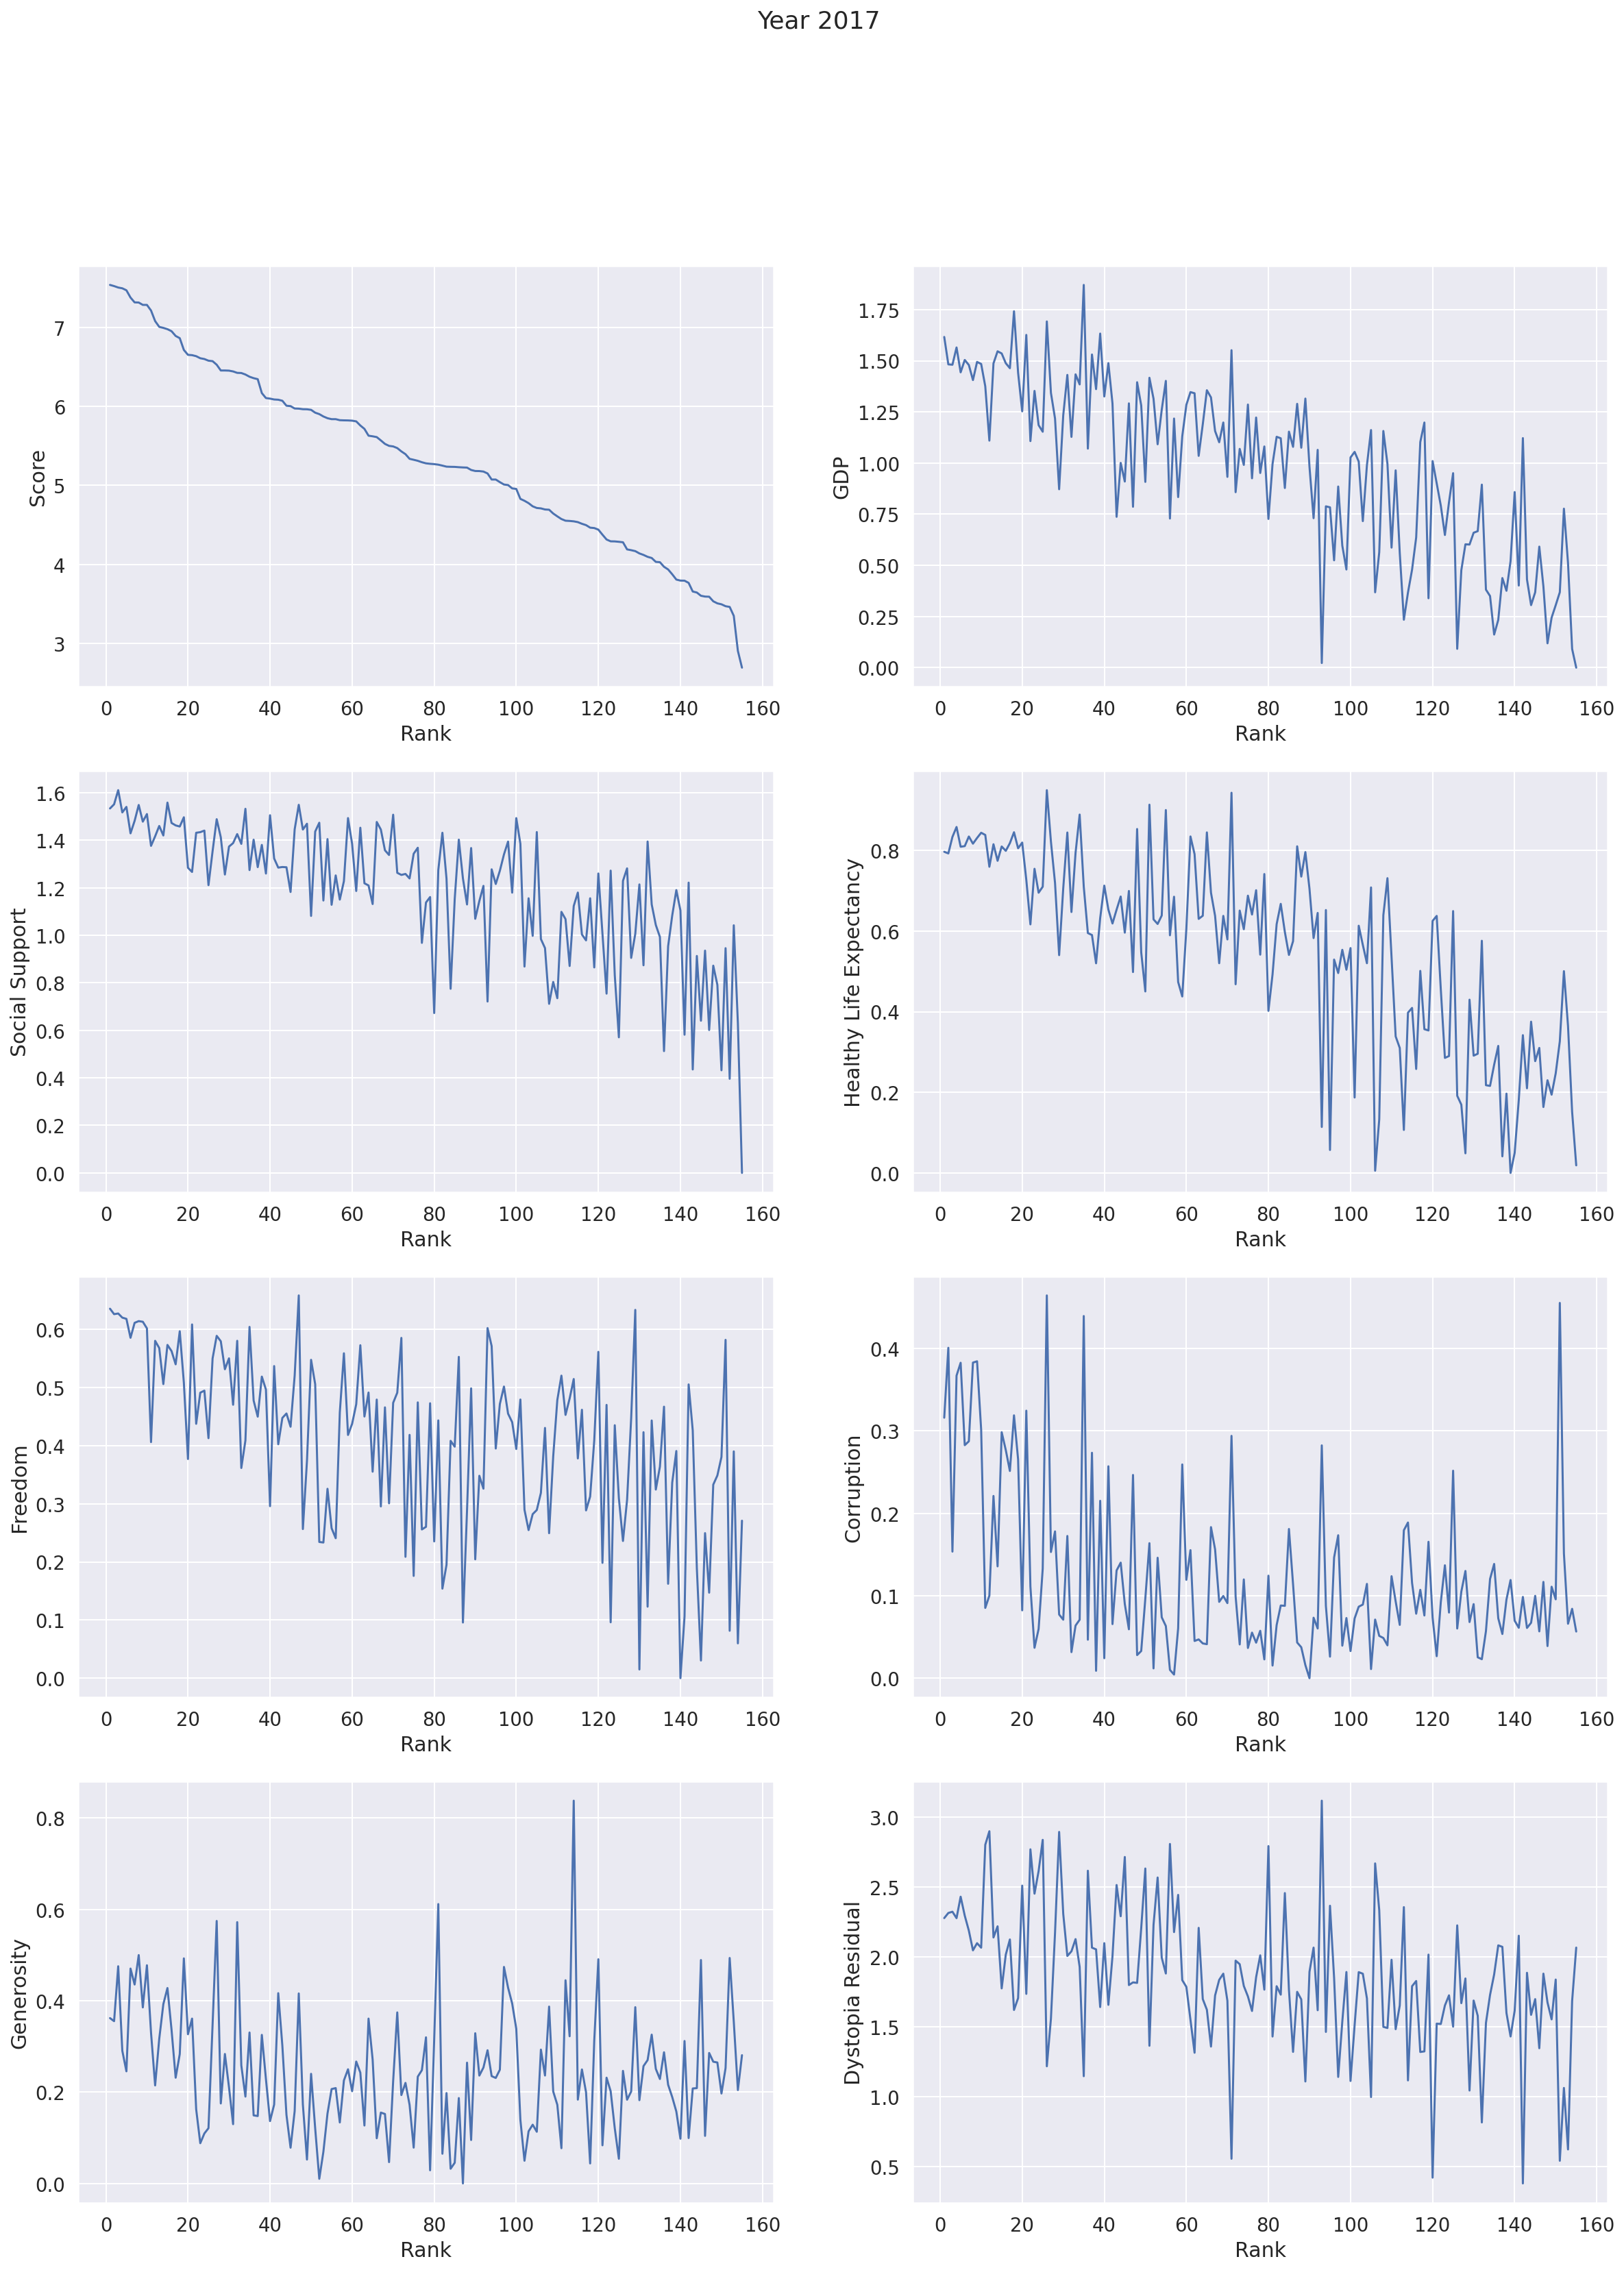

In [427]:
plt.figure(figsize=(20,26))
plt.suptitle('Year 2017')
for iter, feature in enumerate(features_tmp):
    plt.subplot(4,2,iter+1)
    plt.plot(happiness2017.Rank, happiness2017[feature])
    plt.ylabel(feature)
    plt.xlabel('Rank')
plt.show()

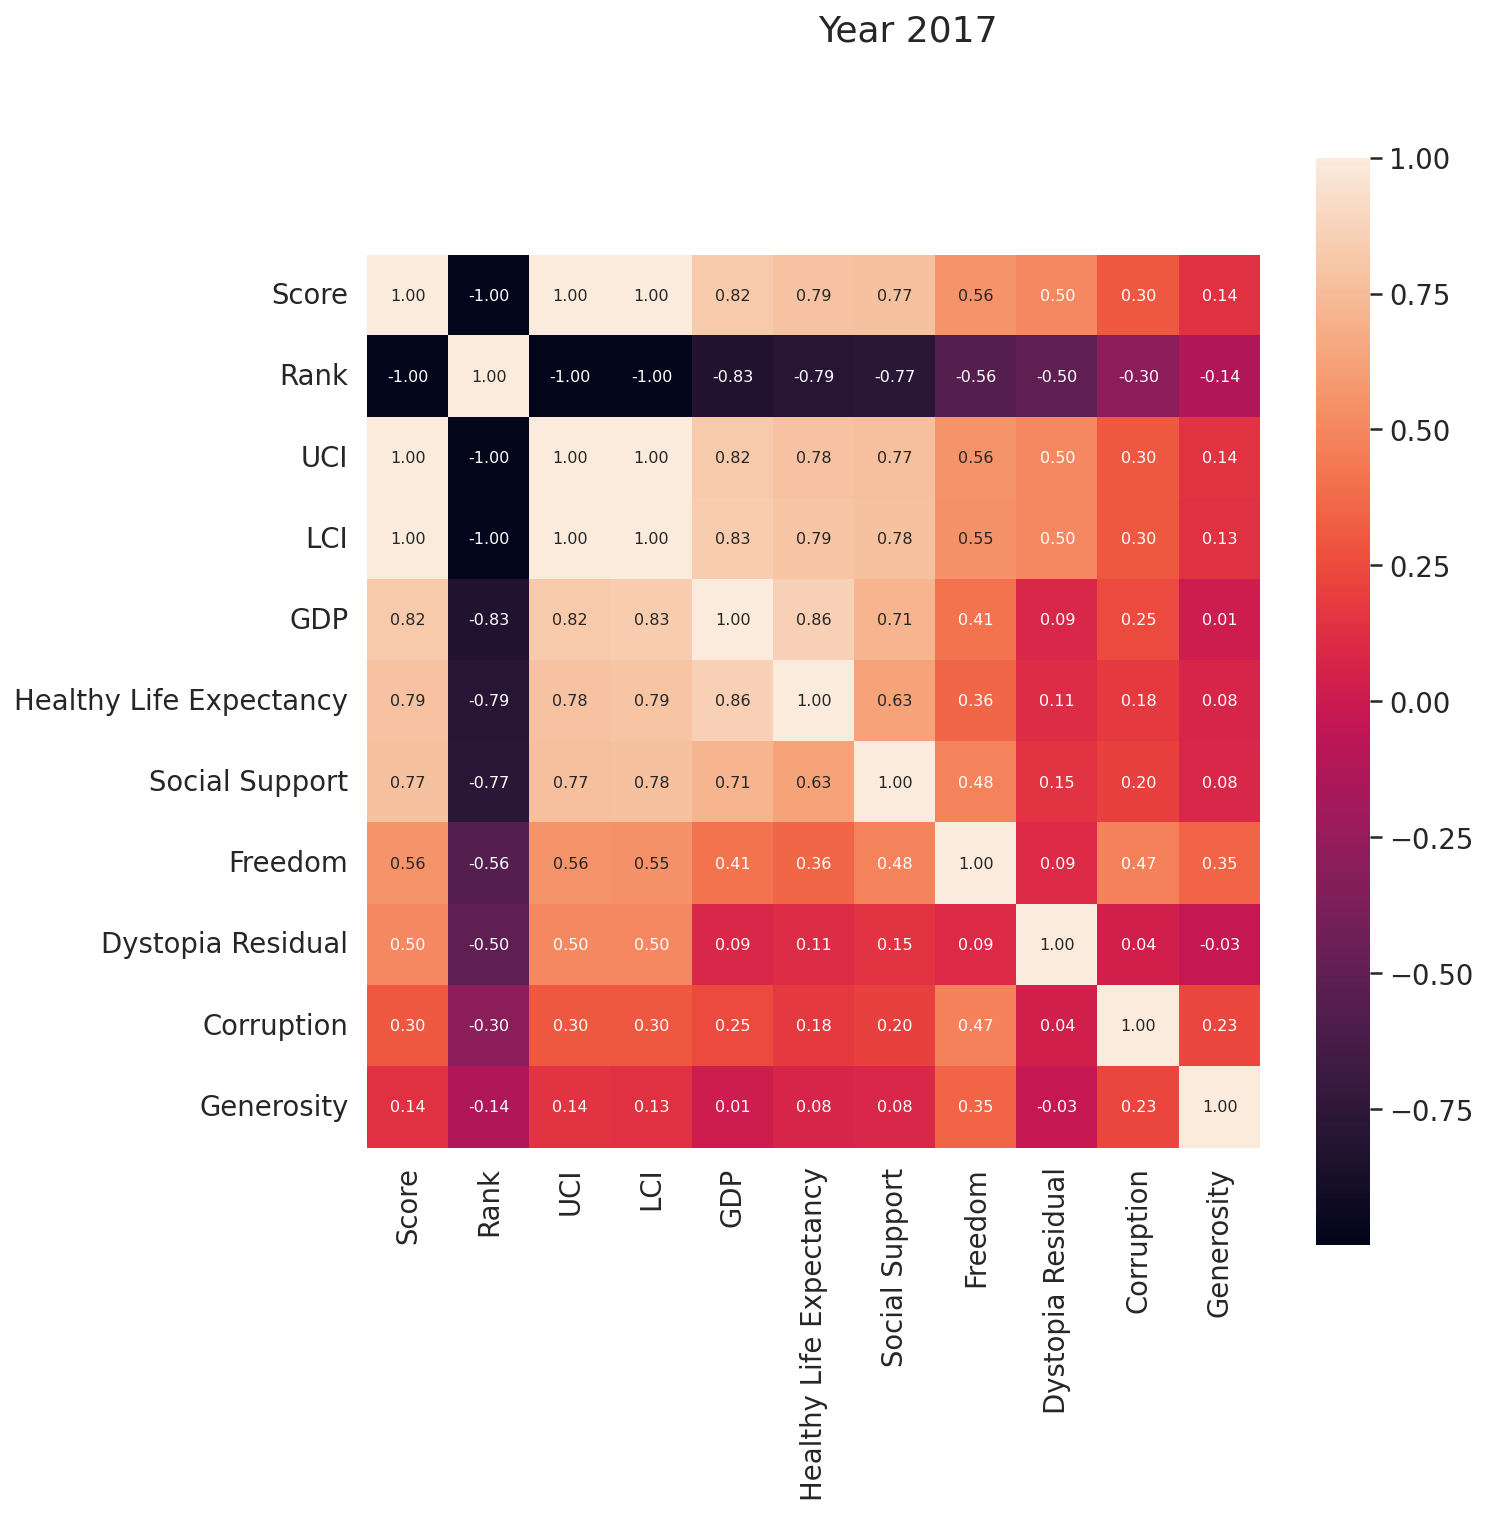

In [428]:
cor_abs = abs(happiness2017.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=11, columns='Score').index
cor = np.array(sp.stats.spearmanr(happiness2017[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.suptitle('Year 2017')
plt.show()

- Dystopia Residual은 Corruption, Generosity보다 값이 더 높은데, 2018-2019년에는 빠진 이유는 무엇인지?

###2. Generosity

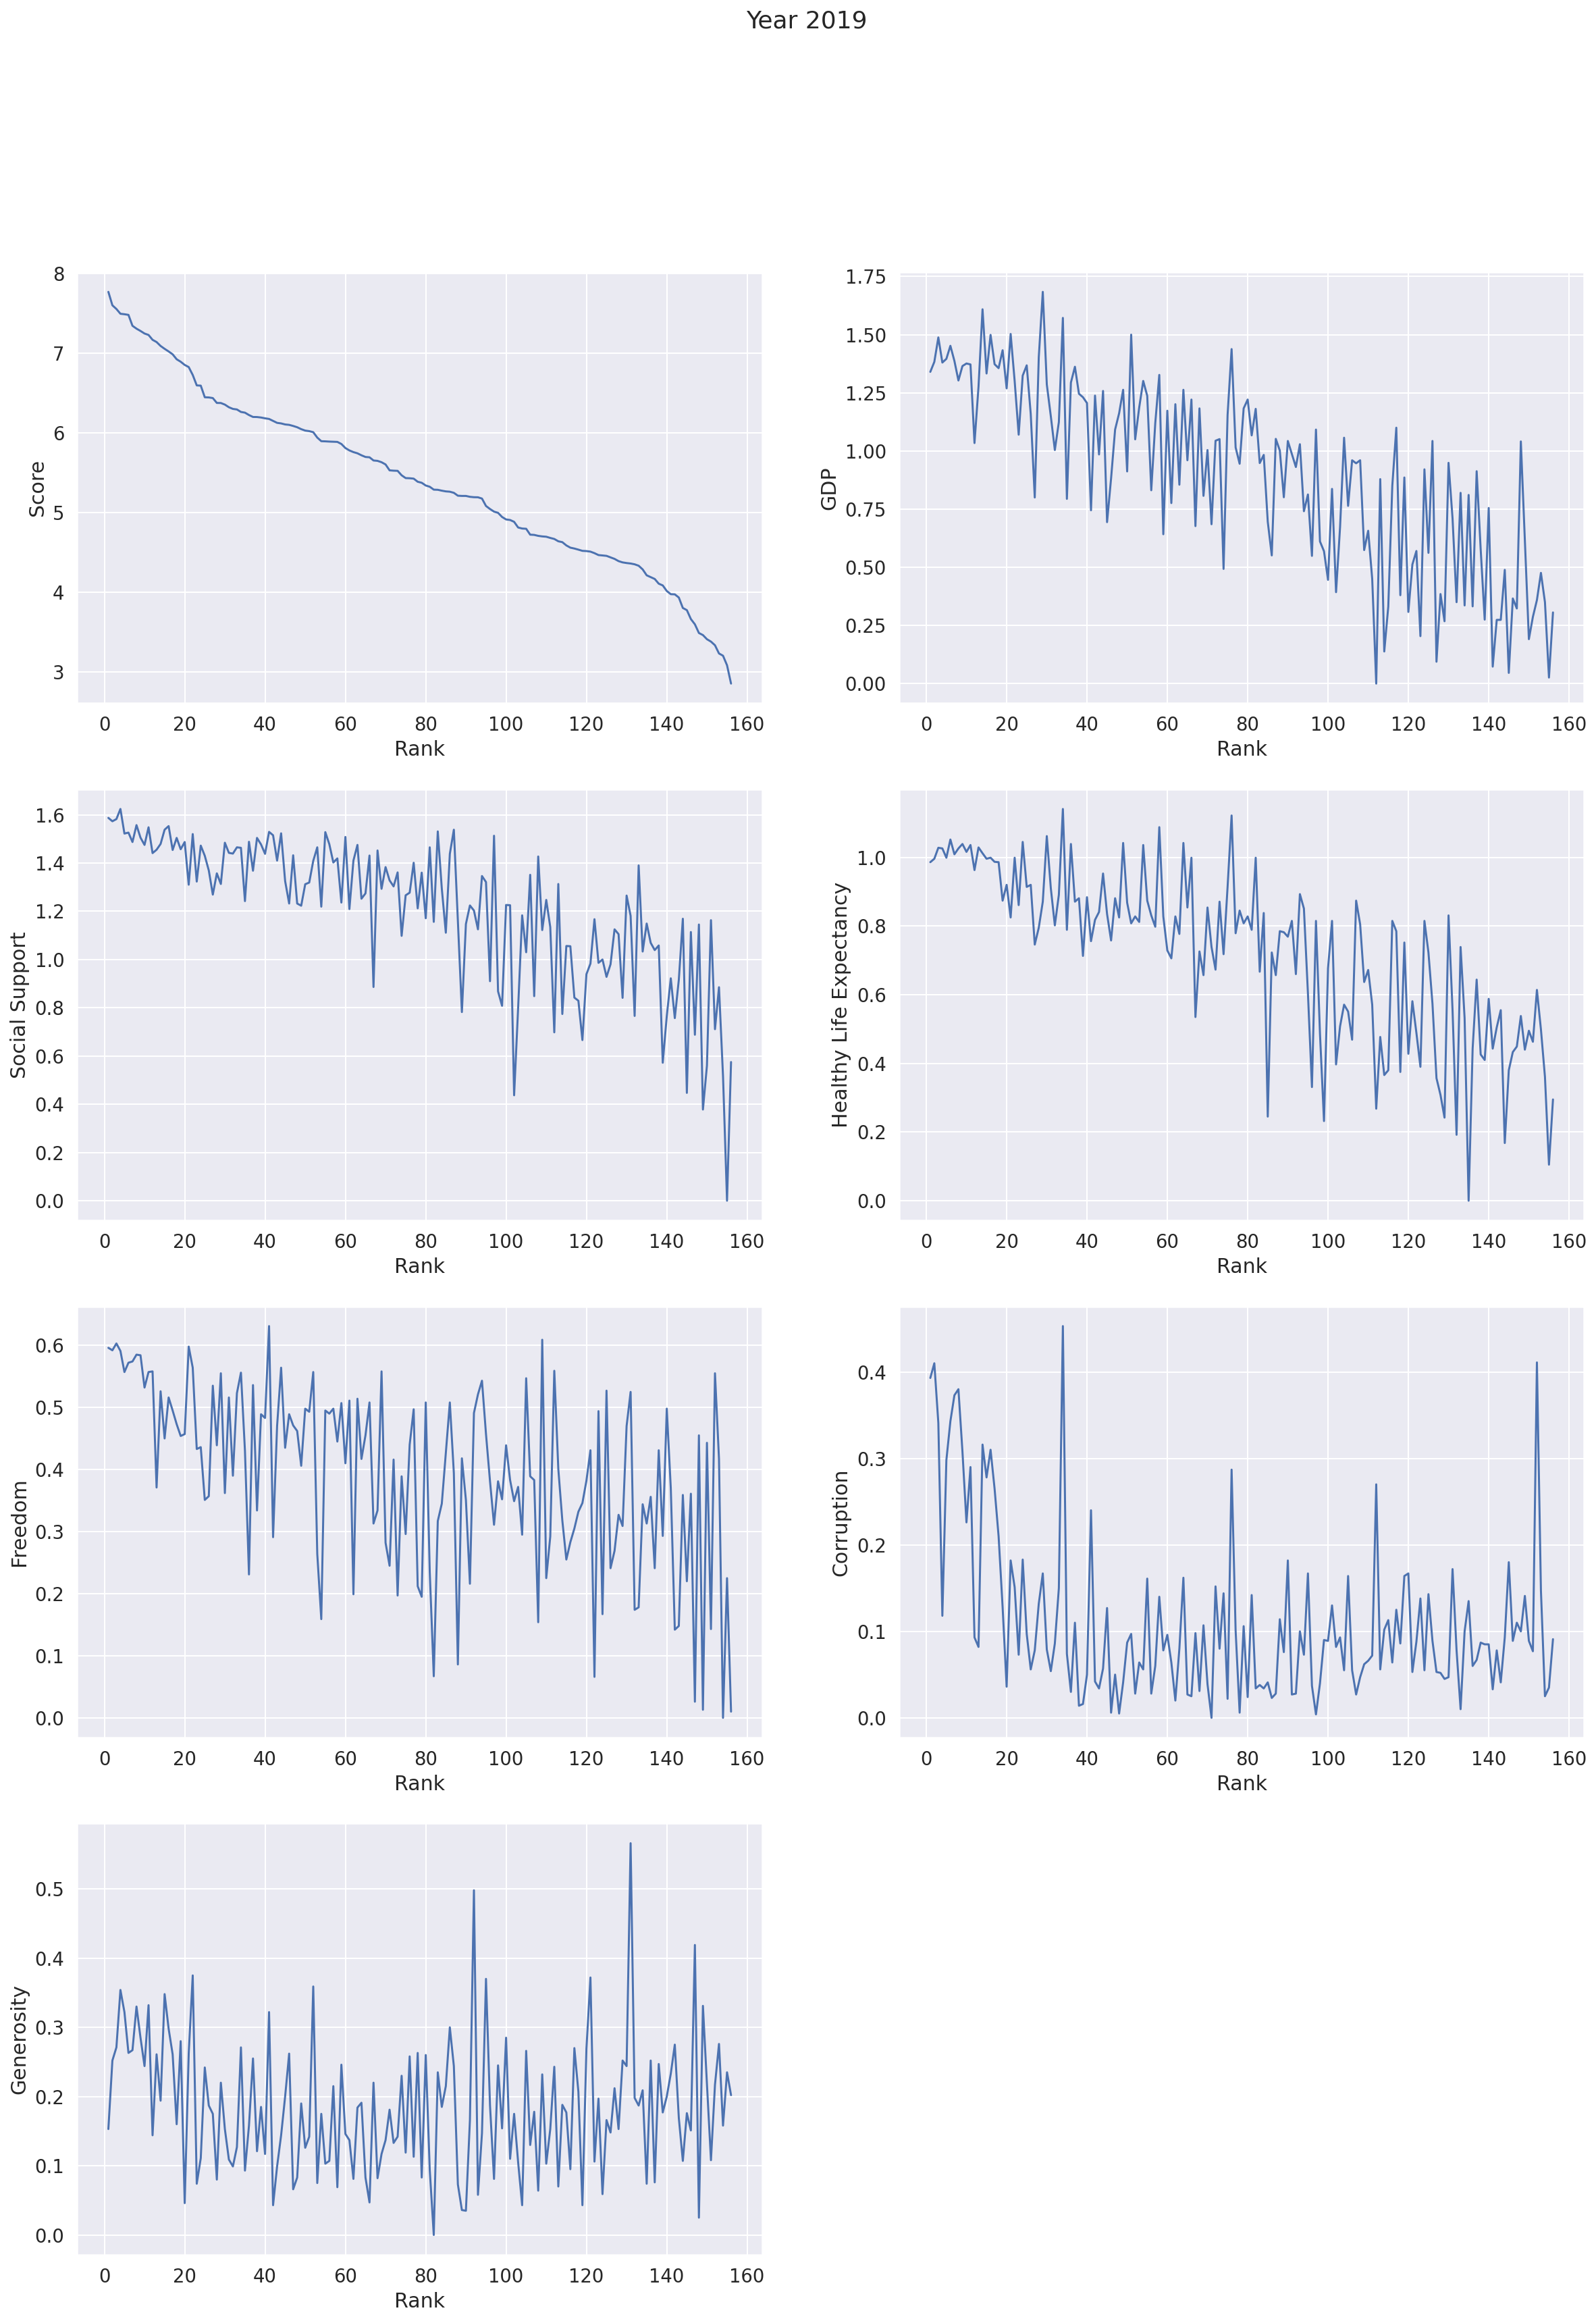

In [429]:
plt.figure(figsize=(20,27))
plt.suptitle('Year 2019')
for iter, feature in enumerate(features_tmp):
    if feature == 'Dystopia Residual':
        continue
    plt.subplot(4,2,iter+1)
    plt.plot(happiness2019.Rank, happiness2019[feature])
    plt.xlabel('Rank')
    plt.ylabel(feature)
plt.show()

- Corruption과 Generosity는 1-40위의 분별력을 위해 추가된 것으로 보임

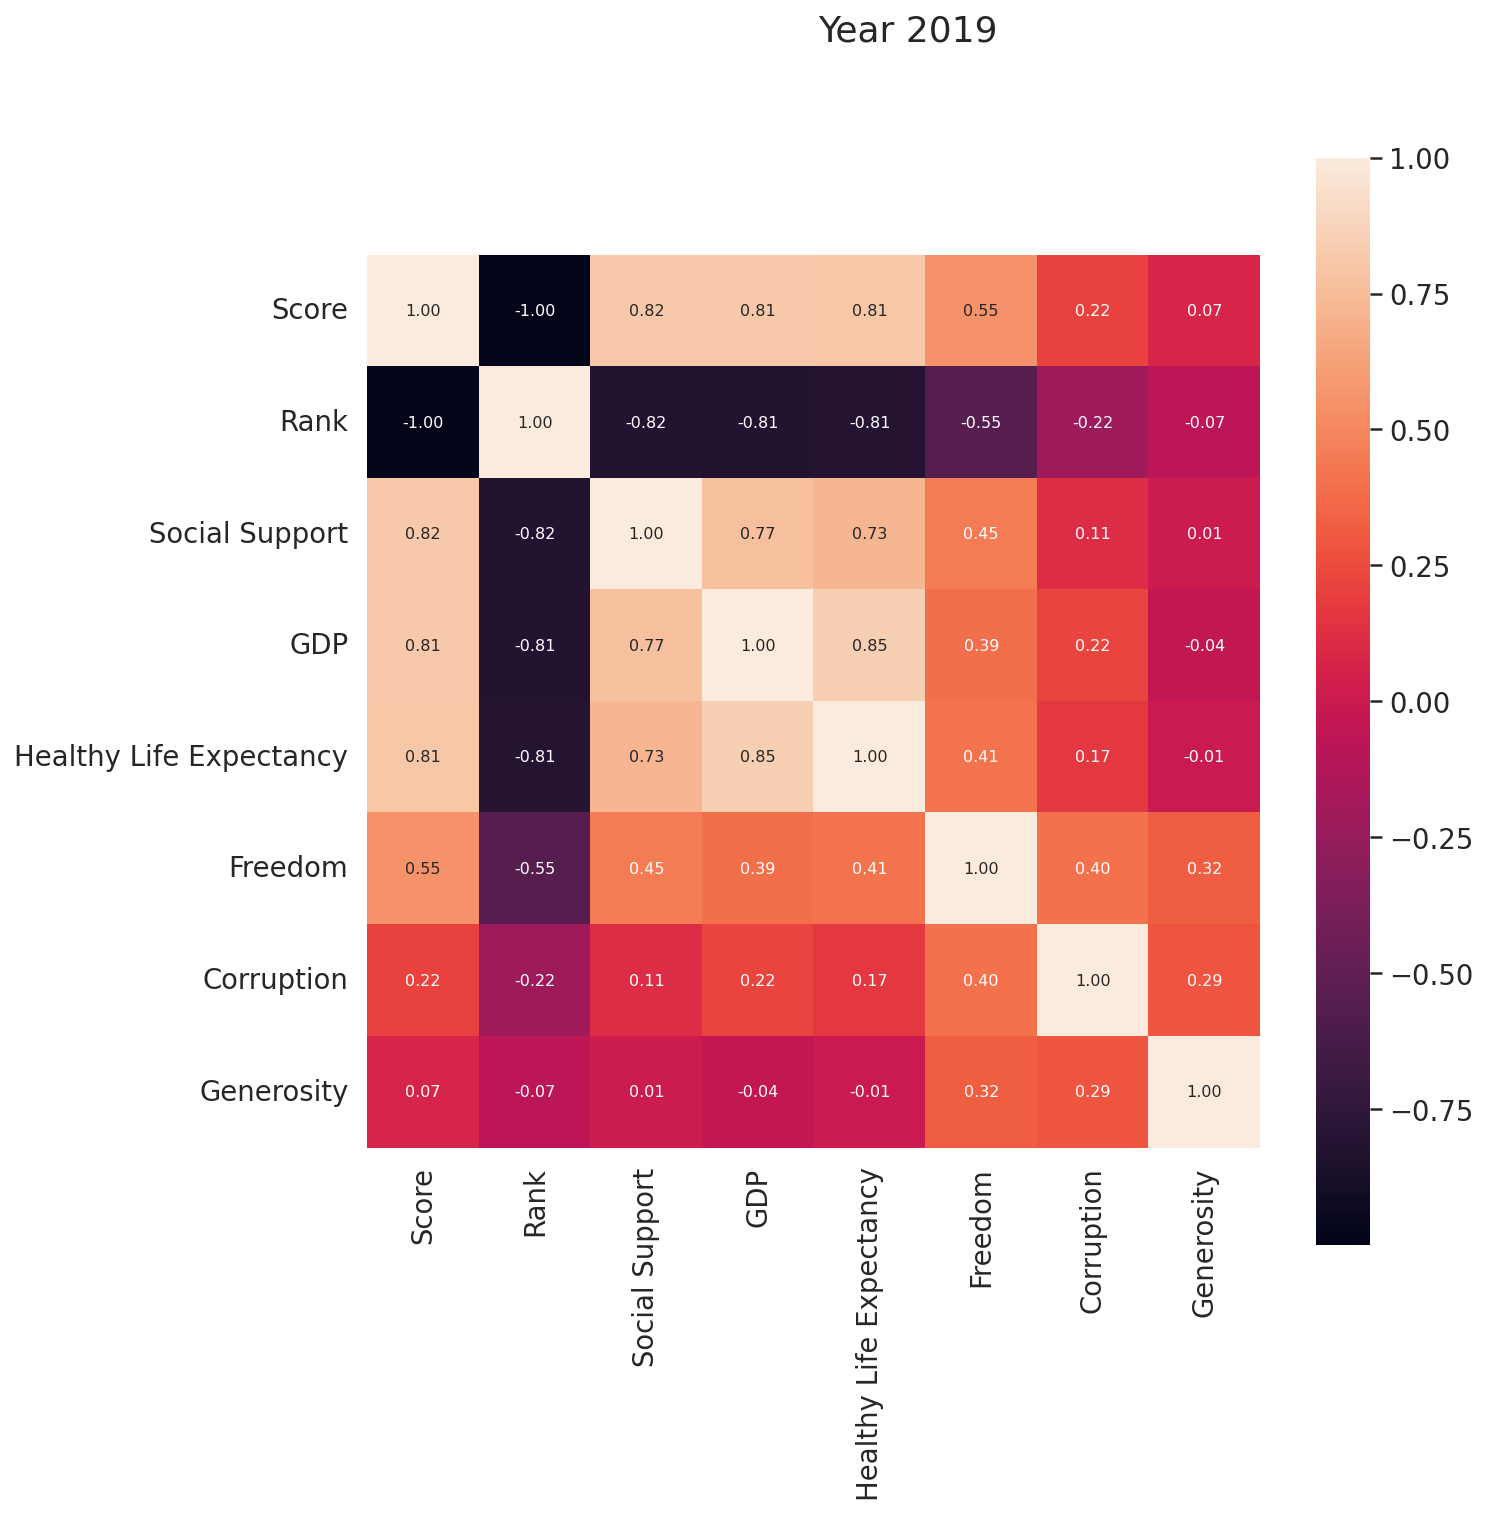

In [430]:
cor_abs = abs(happiness2019.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='Score').index
cor = np.array(sp.stats.spearmanr(happiness2019[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.suptitle('Year 2019')
plt.show()

- Generosity는 가중치가 Corruption보다 높은데 비해, 상관분석에서의 관계성은 가장 낮다

1. 2015-2017년 데이터에서 Dystopia값 제외했을 때 순위 변화 확인하기
 - 2018년부터 해당 피처를 제외했는데, 순위 변화 경향을 확인하면 다른 피처를 제외해도 되는지 판단 기준 나올 것으로 예상

2. 

#한국 데이터 확인

In [431]:
#dataframe 출력 시, 데이터 많을 때 '...'으로 생략하지 않고 전체 다 보여줌
pd.set_option('display.max_columns', None)

2015-2019년 중 한국 데이터 통합

In [432]:
korea = happiness2015.loc[happiness2015.Country == 'South Korea']
for i in happiness[1:]:
    korea = pd.concat([korea, i.loc[i.Country == 'South Korea']], axis=0)

korea = korea[['Rank', 'Score', 'GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']]

korea['Year'] = np.linspace(2015, 2019, 5, dtype=int)
korea = korea.set_index('Year')
display(korea)

,Rank,Score,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual
Year,,,,,,,,,
2015,47,5.984,1.244610,0.957740,0.965380,0.332080,0.078570,0.185570,2.219780
2016,57,5.835,1.359480,0.721940,0.886450,0.251680,0.077160,0.188240,2.350150
2017,55,5.838,1.401678,1.128274,0.900214,0.257922,0.063283,0.206674,1.880378
2018,57,5.875,1.266000,1.204000,0.955000,0.244000,0.051000,0.175000,NaN
2019,54,5.895,1.301000,1.219000,1.036000,0.159000,0.056000,0.175000,NaN


한국의 피처별 그래프 작성

In [433]:
korea = korea.reset_index()

In [434]:
korea['sum'] = korea[['GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']].sum(axis=1).round(3)
display(korea)

,Year,Rank,Score,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual,sum
0,2015,47,5.984,1.244610,0.957740,0.965380,0.332080,0.078570,0.185570,2.219780,5.984
1,2016,57,5.835,1.359480,0.721940,0.886450,0.251680,0.077160,0.188240,2.350150,5.835
2,2017,55,5.838,1.401678,1.128274,0.900214,0.257922,0.063283,0.206674,1.880378,5.838
3,2018,57,5.875,1.266000,1.204000,0.955000,0.244000,0.051000,0.175000,NaN,3.895
4,2019,54,5.895,1.301000,1.219000,1.036000,0.159000,0.056000,0.175000,NaN,3.946


In [435]:
print(5.875 / 3.895)
print(5.895 / 3.946)
#2018-2019년도 Score = 1.5 * sum

1.508344030808729
1.4939178915357323


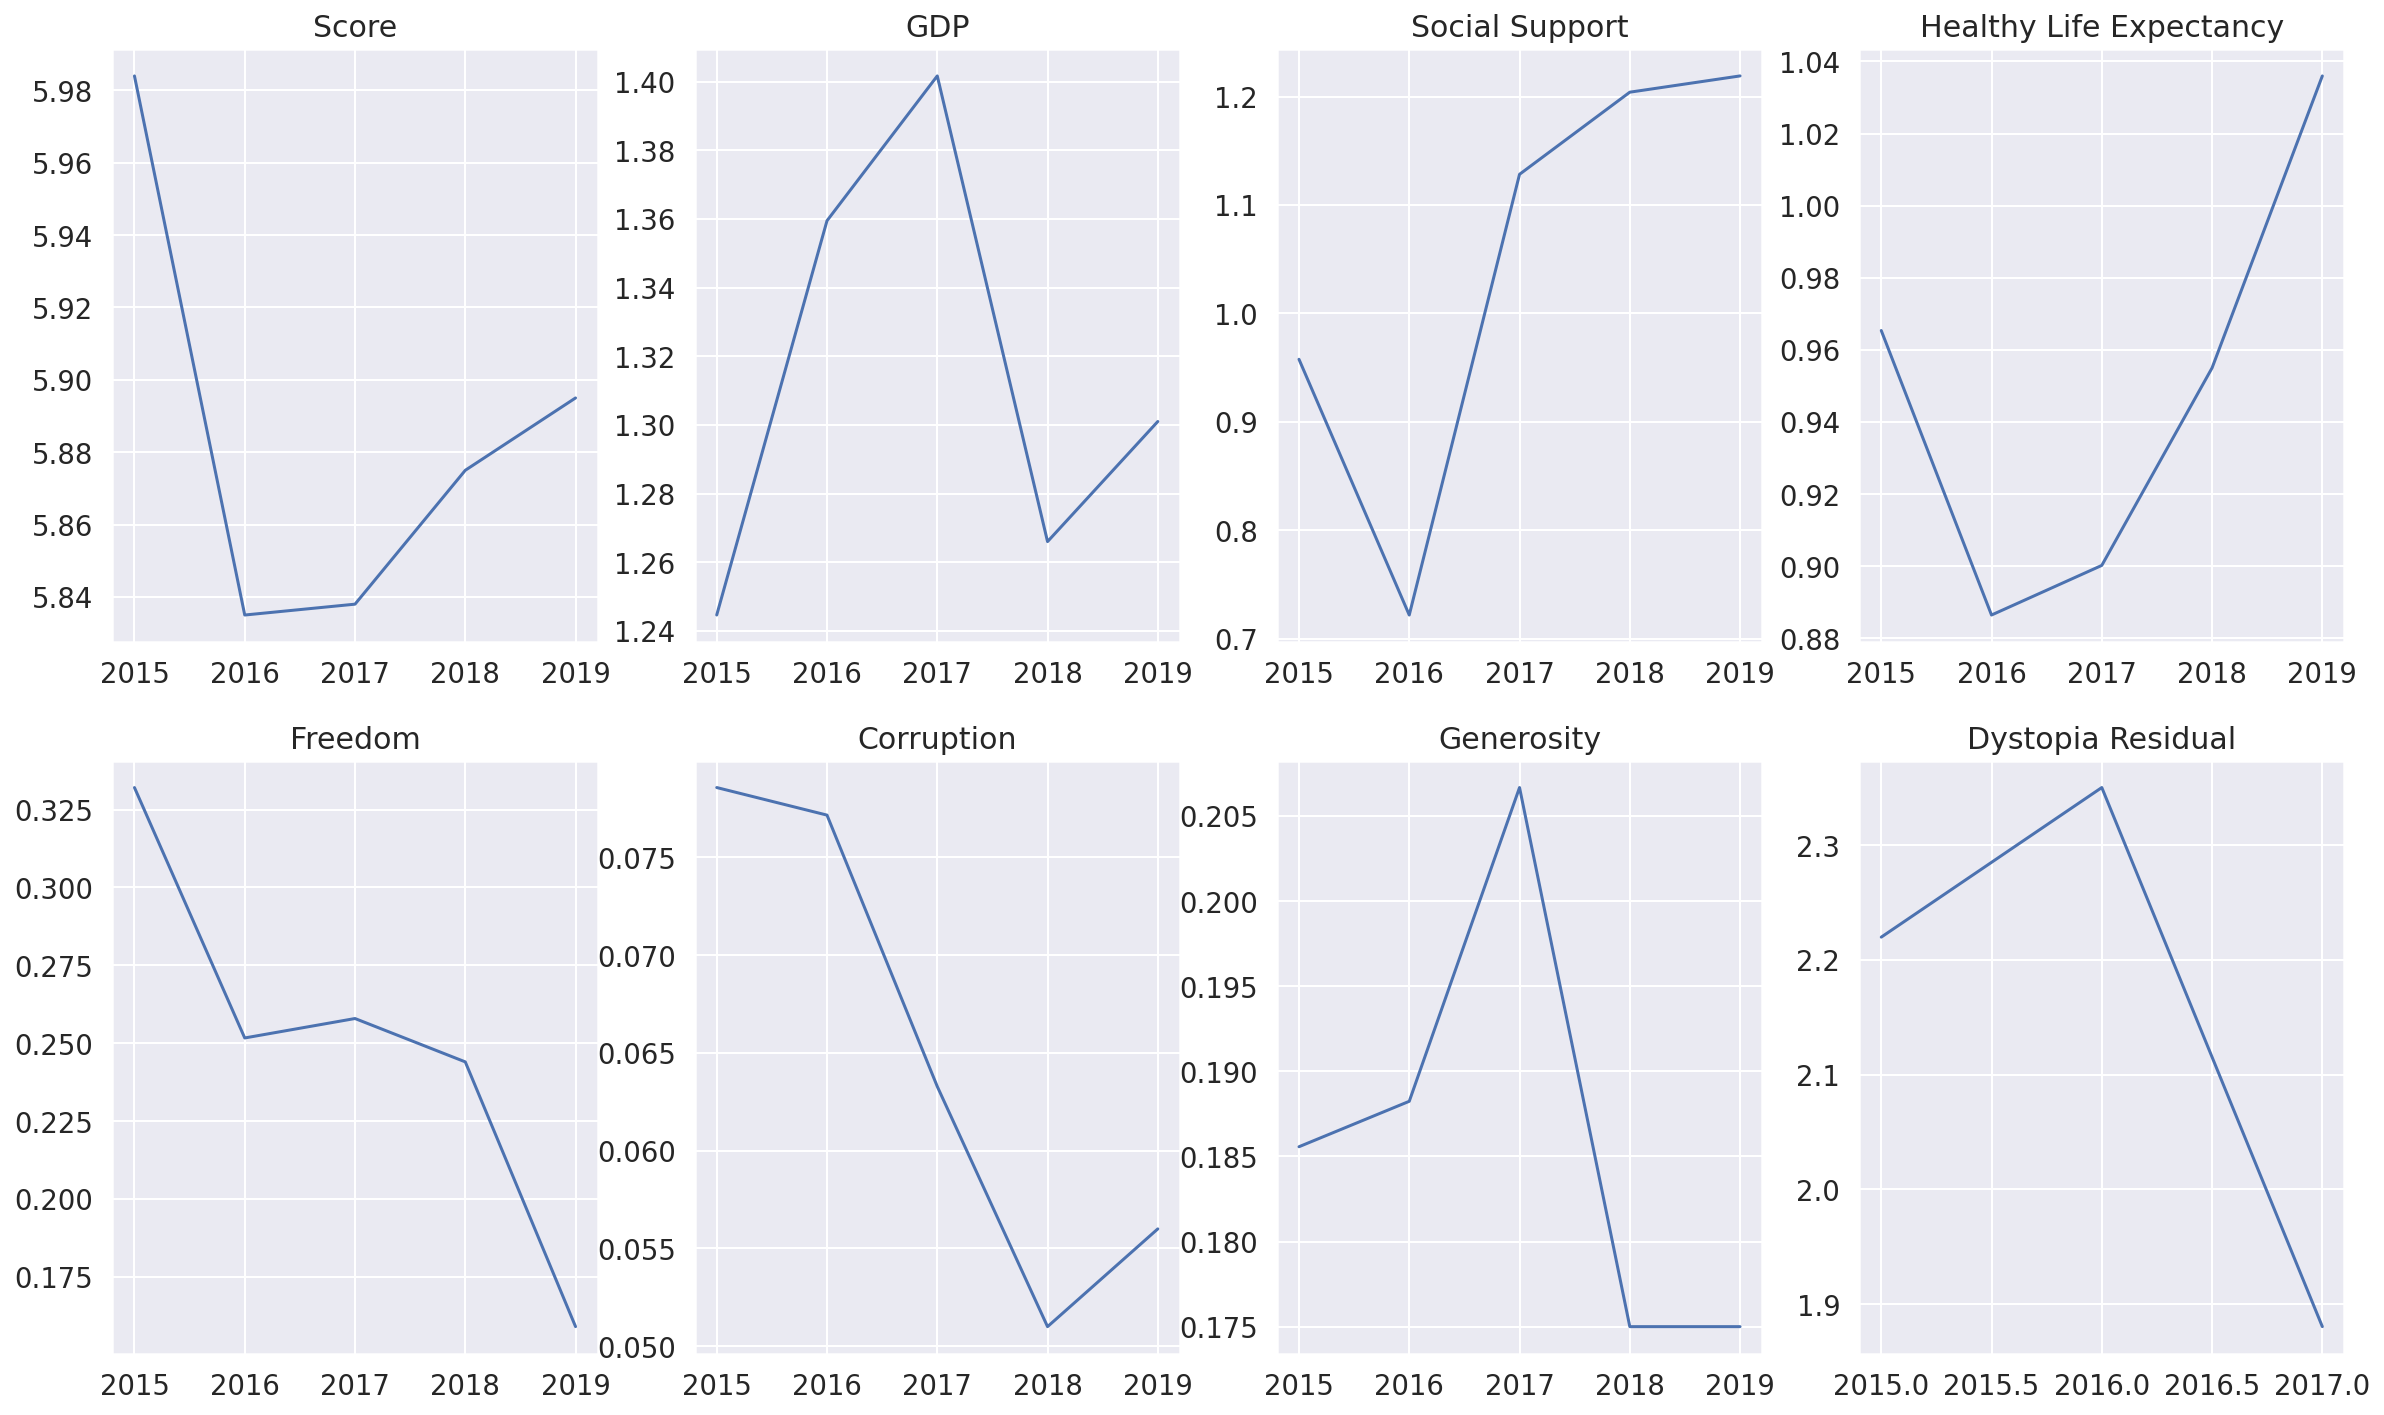

In [437]:
plt.figure(figsize=(20,12))
for iter, feature in enumerate(features_tmp):
    plt.subplot(2,4,iter+1)
    plt.plot(korea.Year, korea[feature])
    plt.title(feature)
    ymin = statistics[feature]['min']
    ymax = statistics[feature]['max']
    plt.ylim(ymin, ymax)
plt.show()

#대륙별 데이터 확인